# PEFT(Parameter-Efficient Fine-Tuning) on Pre-trained Model with Cell Population Discovery
In this tutorial, we demonstrate how to peft a pre-trained model on a new dataset for the cell population discovery task. We use the immune dataset as an example and peft on the pre-trained model. 

We summarize the peft pipeline in the following steps, which can be used as a general recipe for peft on the cell population discovery tasks and beyond: 

     1. Specify hyper-parameter setup for cell population discovery task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. PEFT scGPT with MLM and GEPC objectives
     
     5. Evaluate PEFT scGPT


In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
from typing import List, Tuple, Dict, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import shutil
import numpy as np
import pandas as pd
import argparse
from scipy.sparse import issparse
from tqdm import tqdm
from torch import nn
from einops import rearrange
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import TFPreprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, load_tfs, load_pretrained, PeftConfig, freeze_parameters, DownstreamTasks

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/tutorial_peft/../scgpt/model/model.py:22: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/tutorial_peft/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


## Step1: Specify hyper-parameter setup for cell population discovery task
Here we provide some hyper-parameter recommendations here for the cell population discovery task. Note that the MLM and GEPC objectives are on to facilitate cell population discovery task.

In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="immune",  # Dataset name
    do_train=True,  # Flag to indicate whether to do update model parameters during training
    load_model="../save/scGPT_human",  # Path to pre-trained model
    GEPC=True,  # Gene expression modelling for cell objective
    DAB=False,  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
    MLM=True,  # whether to use masked language modeling, currently it is always on.
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    mlm_probability=[0.15, 0.25, 0.4],  # Default mask ratio
    epochs=20,  # Default number of epochs for peft
    n_bins=51,  # Default number of bins for value binning in data pre-processing
    lr=1e-4,  # Default learning rate for peft
    batch_size=32,  # Default batch size for peft
    schedule_ratio=0.9,  # Default rate for learning rate decay
    dropout=0.2,  # Default dropout rate during model peft
    save_interval=5,  # Default model evaluation interval
    log_interval=100,  # Default log interval
    fast_transformer=False,  # Default setting
    pre_norm=False,  # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
    include_zero_gene=False,
    peft="HYBRID"
    # Whether using Parameter-Efficient Fine-Tuning,
    # False to disable, HYBRID/ENCODER/TOKEN/PREFIX/LORA are available for selection
)

config = argparse.Namespace(**hyperparameter_defaults)
print(config)

set_seed(config.seed)

Namespace(seed=42, dataset_name='immune', do_train=True, load_model='../save/scGPT_human', GEPC=True, DAB=False, MLM=True, ecs_thres=0.8, mlm_probability=[0.15, 0.25, 0.4], epochs=20, n_bins=51, lr=0.0001, batch_size=32, schedule_ratio=0.9, dropout=0.2, save_interval=5, log_interval=100, fast_transformer=False, pre_norm=False, amp=True, include_zero_gene=False, peft='HYBRID')


In [3]:
# settings for parameter efficient fine tuning
assert config.peft in [False, "HYBRID", "ENCODER", "TOKEN", "PREFIX", "LORA"]
peft_config = PeftConfig(peft_type=config.peft, use_default_settings=True).to_dict()

# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 2000  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = False
include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
explicit_zero_prob = config.MLM and config.include_zero_gene  # whether explicit bernoulli for zeros
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier

In [4]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/peft_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/peft_immune-Aug23-03-38


## Step 2: Load and pre-process data
### 2.1 Load the immune data
The immune dataset can be downloaded via this [link](https://drive.google.com/file/d/1L2UGuvACWh7p_PM9n4awNh6DPcjWv4Jy/view?usp=sharing). 

In [5]:
if dataset_name == 'immune':
    data_dir = Path("../data/cell_population_discovery")
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")

    data_is_raw = True
    adata.obs["celltype"] = adata.obs["annot"]
    adata.obs["str_batch"] = adata.obs["batch"]

# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

Unlike the official scGPT, we have added human_transcript_factor to the gene list in this task 

In [7]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)

    # load tfs
    tfs_file_path = Path("human_transcription_factors.txt")
    tfs = load_tfs(tfs_file_path, vocab)
    logger.info(f"Load human transcription factors from {tfs_file_path}")

    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]


scGPT - INFO - match 19533/19533 genes in vocabulary of size 60697.
scGPT - INFO - Load human transcription factors from human_transcription_factors.txt


### 2.2 Pre-process the data
We follow the pipline of depth normalization, log normalization, highly vairable gene (HVG) selection for data pre-processing. Additionally, we append transcription factors (TFs) to the gene list.

In [8]:
# set up the TFpreprocessor, use the args to config the workflow
preprocessor = TFPreprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
    tfs=tfs  # whether add tfs to the gene set
)

adata = preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Appending transcription factor to gene list ...
scGPT - INFO - Binning data ...


### 2.3 Tokenize the input data for model peft

In [9]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

# For batch correction
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids)) if config.DAB else None
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, batch_ids, test_size=0.1, shuffle=True
)


In [10]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)


In [11]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 18210, 
	 feature length: 784
scGPT - INFO - valid set number of samples: 2024, 
	 feature length: 774


In [12]:
def prepare_data(mask_ratio: float = 0.4) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
        except_cls=True
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
        except_cls=True
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
        data_pt: Dict[str, torch.Tensor],
        batch_size: int,
        shuffle: bool = False,
        intra_domain_shuffle: bool = False,
        drop_last: bool = False,
        num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


 ## Step 3: Load the pre-trained scGPT model
 We load the pre-trained scGPT model and freeze specific parameters. The specific parameters to be frozen or opened depend on the downstream tasks and the type of adapter used. Here, we only need to specify specific downstream tasks

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ntokens = len(vocab)  # size of vocabulary

model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=config.DAB,
    num_batch_labels=num_batch_types,
    use_batch_labels=INPUT_BATCH_LABELS,
    n_input_bins=n_input_bins,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    peft_config=peft_config
)

if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

if config.peft:
    freeze_parameters(model, DownstreamTasks.CellPopulationDiscovery)

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info("-" * 89)
learnable_params = {k: v for k, v in model.named_parameters() if v.requires_grad}
for k, v in learnable_params.items():
    logger.info(f"Learnable params {k} with shape {v.shape}")

logger.info("Total Pre freeze Params: %.2fM" % (pre_freeze_param_count / 1e6,))
logger.info("Total Post freeze Params: %.2fM" % (post_freeze_param_count / 1e6,))

model.to(device)

criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Learnable params value_encoder.adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params value_encoder.adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params value_encoder.adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params value_encoder.adapter.fc2.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc2.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_enc

In [14]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc, total_zero_log_prob, total_dab = 0.0, 0.0, 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=None,
                MVC=config.GEPC,
                ECS=False,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = 0.0
            if config.MLM:
                loss_mse = criterion(
                    output_dict["mlm_output"], target_values, masked_positions
                )
                loss = loss + loss_mse

            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob

            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc

            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob

            if config.DAB:
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
                loss = loss + loss_dab

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item() if config.MLM else 0.0
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_dab += loss_dab.item() if config.DAB else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_dab = total_dab / log_interval if config.DAB else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.5f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
                + (f"dab {cur_dab:5.2f} |" if config.DAB else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            total_dab = 0
            start_time = time.time()


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    return total_loss / total_num, total_error / total_num


def eval_testdata(
        model: nn.Module,
        adata_t: AnnData,
        include_types: List[str] = ["cls"],
) -> Optional[AnnData]:
    """evaluate the model on dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=include_zero_gene,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

    return adata_t

## Step 4: PEFT scGPT with task-specific objectives
Now we are starting PEFT(Parameter-Efficient Fine-Tuning) scGPT. In the cell population discovery task, we use MLM and GEPC objectives to train scGPT

In [15]:
best_val_loss = float("inf")
best_model = None

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    mask_ratio = np.random.choice(config.mlm_probability)
    train_data_pt, valid_data_pt = prepare_data(mask_ratio=mask_ratio)

    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_interval == 0:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

    scheduler.step()


random masking at epoch   1, ratio of masked values in train:  0.3974
scGPT - INFO - | epoch   1 | 100/570 batches | lr 0.00010 | ms/batch 251.49 | loss 306.46 | mse 160.74 | mre  1.45 |gepc 145.72 |
scGPT - INFO - | epoch   1 | 200/570 batches | lr 0.00010 | ms/batch 222.49 | loss 278.89 | mse 141.18 | mre  1.34 |gepc 137.71 |
scGPT - INFO - | epoch   1 | 300/570 batches | lr 0.00010 | ms/batch 223.23 | loss 274.00 | mse 138.02 | mre  1.33 |gepc 135.98 |
scGPT - INFO - | epoch   1 | 400/570 batches | lr 0.00010 | ms/batch 223.73 | loss 270.66 | mse 136.00 | mre  1.30 |gepc 134.66 |
scGPT - INFO - | epoch   1 | 500/570 batches | lr 0.00010 | ms/batch 223.96 | loss 270.24 | mse 135.67 | mre  1.31 |gepc 134.57 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 135.88s | valid loss/mse 133.4277 | mre 1.2878
scGPT - INFO - -----------------------------------------------------------------------

scGPT - INFO - | end of epoch   8 | time: 133.52s | valid loss/mse 130.4141 | mre 1.3077
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 130.4141
random masking at epoch   9, ratio of masked values in train:  0.2479
scGPT - INFO - | epoch   9 | 100/570 batches | lr 0.00004 | ms/batch 226.22 | loss 264.88 | mse 132.25 | mre  1.30 |gepc 132.63 |
scGPT - INFO - | epoch   9 | 200/570 batches | lr 0.00004 | ms/batch 223.97 | loss 263.88 | mse 131.74 | mre  1.31 |gepc 132.14 |
scGPT - INFO - | epoch   9 | 300/570 batches | lr 0.00004 | ms/batch 223.98 | loss 261.47 | mse 130.50 | mre  1.29 |gepc 130.97 |
scGPT - INFO - | epoch   9 | 400/570 batches | lr 0.00004 | ms/batch 224.00 | loss 261.18 | mse 130.38 | mre  1.28 |gepc 130.79 |
scGPT - INFO - | epoch   9 | 500/570 batches | lr 0.00004 | ms/batch 224.00 | loss 261.77 | mse 130.68 | mre  1.28 |gepc 131.09 |
scGPT - INFO - -------------------------

scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  16 | time: 133.52s | valid loss/mse 130.1812 | mre 1.2873
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  17, ratio of masked values in train:  0.1480
scGPT - INFO - | epoch  17 | 100/570 batches | lr 0.00002 | ms/batch 226.11 | loss 264.37 | mse 131.91 | mre  1.30 |gepc 132.46 |
scGPT - INFO - | epoch  17 | 200/570 batches | lr 0.00002 | ms/batch 223.95 | loss 261.45 | mse 130.46 | mre  1.29 |gepc 130.99 |
scGPT - INFO - | epoch  17 | 300/570 batches | lr 0.00002 | ms/batch 223.91 | loss 260.56 | mse 130.17 | mre  1.28 |gepc 130.39 |
scGPT - INFO - | epoch  17 | 400/570 batches | lr 0.00002 | ms/batch 224.25 | loss 260.18 | mse 129.96 | mre  1.29 |gepc 130.23 |
scGPT - INFO - | epoch  17 | 500/570 batches | lr 0.00002 | ms/batch 224.28 | loss 259.11 | mse 129.36 | mre  1

In [16]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

## Step 5: Evaluate PEFT scGPT


scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 633/633 [00:59<00:00, 10.66it/s]


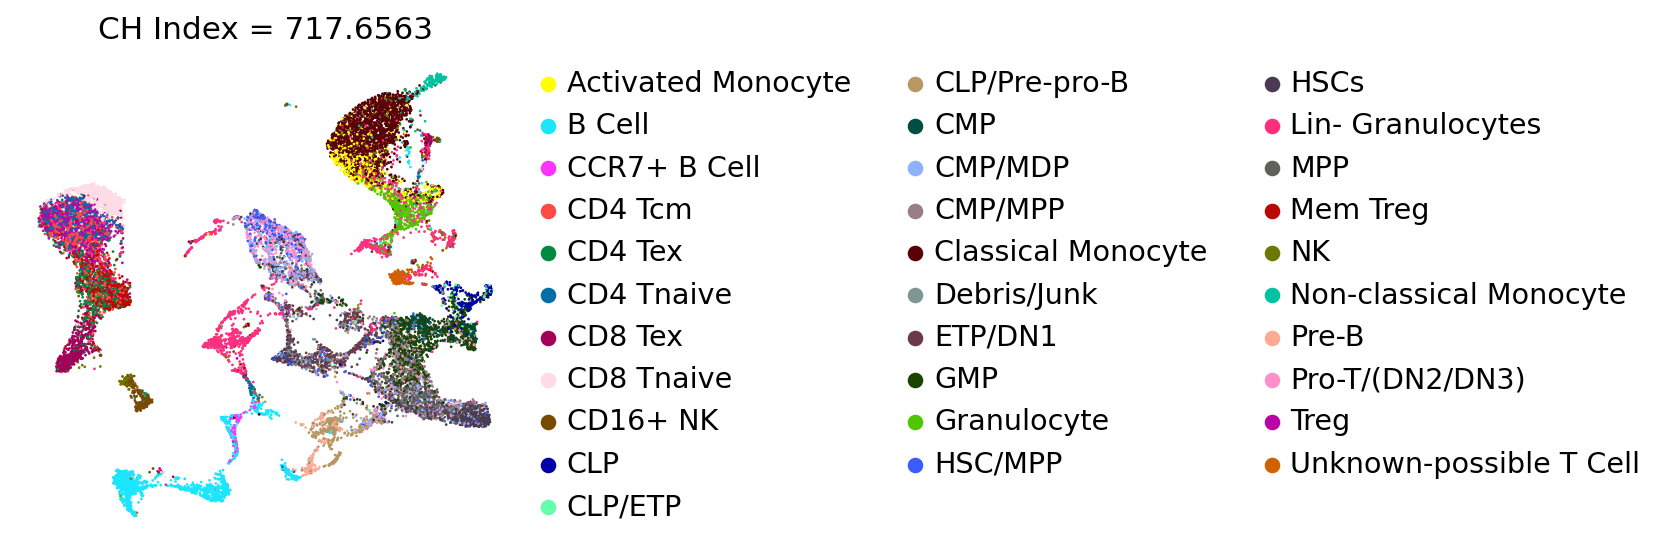

In [17]:
adata_t = eval_testdata(
    best_model,
    adata_t=adata,
    include_types=["cls"],
)

from sklearn.metrics import calinski_harabasz_score

CH_Index = calinski_harabasz_score(X=adata_t.obsm["X_scGPT"], labels=adata_t.obs["celltype"])

sc.pp.neighbors(adata_t, use_rep="X_scGPT")
sc.tl.umap(adata_t, min_dist=0.3)
sc.pl.umap(adata_t, color="celltype", title=[f"CH Index = {CH_Index:.4f}"], frameon=False, show=True)